# Triplet Loss Pre-training

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf

import matplotlib.pyplot as plt
from ipywidgets import interact

import tensorflow_addons as tfa
from tensorflow.keras.models import load_model
from tensorflow_addons.losses import TripletSemiHardLoss, TripletHardLoss

from beeid.utils import sensitivity_map

from code.models import simple_cnnv2
from code.data_utils import load_tf_dataset
from code.viz import show_sensitivity_maps
from code.evaluation import cmc_evaluation, plot_cmc
from code.evaluation import get_interactive_plot_query_gallery


# np.random.seed(42)

### Prepare dataset

Select the dates for Training, Validation and Testing datasets.

In [2]:
df=pd.read_csv("data/untagged_dataset.csv")

In [3]:
TRACKS_NUM=1448

tracks_ids = df.global_track_id.unique()
rand_tracks_ids = np.random.permutation(tracks_ids)
selected_tracks_ids = rand_tracks_ids[:TRACKS_NUM]

selected_images = df.global_track_id.isin(selected_tracks_ids)
df = df[selected_images]

In [4]:
labels = df.label.unique()
train_num = int(len(labels)*0.8)
rand_labels = np.random.permutation(len(labels))
train_labels = rand_labels[:train_num]

In [5]:
train_df = df[df.label.isin(train_labels)]
valid_df = df[~df.label.isin(train_labels)]

### Tensorflow Dataset

In [6]:
train_dataset = load_tf_dataset(train_df, rescale_factor=4, augmentation=True, label_column="label").shuffle(len(train_df))
valid_dataset = load_tf_dataset(valid_df, rescale_factor=4, label_column="label")

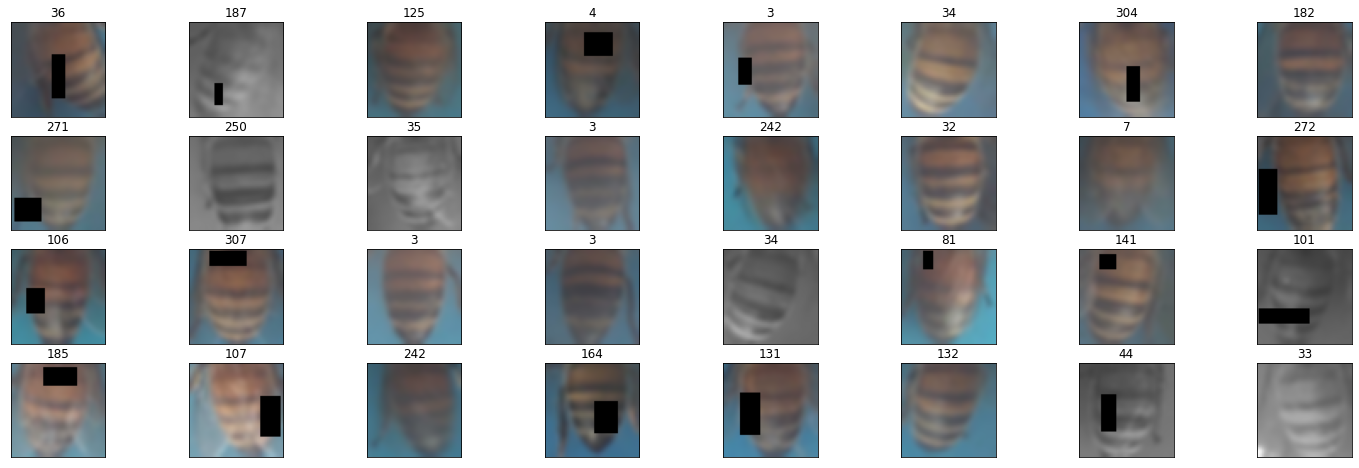

In [7]:
data = train_dataset.batch(32)
gen = iter(data)
sample_batch = next(gen)

EXAMPLES=2

fig, ax = plt.subplots(4, 8, figsize=(25, 8))
ax = ax.ravel()
for j in range(32):
    ax[j].imshow(sample_batch[0][j])
    ax[j].set_title("{}".format(sample_batch[1][j].numpy()))
    ax[j].set_xticks([])
    ax[j].set_yticks([])

### Model

In [8]:
model = simple_cnnv2(input_shape=(56, 56, 3), conv_blocks=3, latent_dim=128)

In [9]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
    loss=TripletSemiHardLoss(margin=0.2))

In [10]:
# Train the network
BATCH_SIZE=256
EPOCHS=1000
PATIENCE=100

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

history = model.fit(train_dataset.batch(BATCH_SIZE), validation_data=valid_dataset.batch(BATCH_SIZE), epochs=EPOCHS, callbacks=[earlystop])

Epoch 1/1000
28/28 [==============================] - 42s 1s/step - loss: 0.1910 - val_loss: 0.1769
Epoch 2/1000
28/28 [==============================] - 20s 729ms/step - loss: 0.1747 - val_loss: 0.1748
Epoch 3/1000
28/28 [==============================] - 24s 864ms/step - loss: 0.1603 - val_loss: 0.1800
Epoch 4/1000
28/28 [==============================] - 19s 694ms/step - loss: 0.1514 - val_loss: 0.1678
Epoch 5/1000
28/28 [==============================] - 23s 835ms/step - loss: 0.1433 - val_loss: 0.1682
Epoch 6/1000
28/28 [==============================] - 18s 632ms/step - loss: 0.1350 - val_loss: 0.1638
Epoch 7/1000
28/28 [==============================] - 24s 859ms/step - loss: 0.1294 - val_loss: 0.1601
Epoch 8/1000
28/28 [==============================] - 17s 622ms/step - loss: 0.1235 - val_loss: 0.1547
Epoch 9/1000
28/28 [==============================] - 23s 806ms/step - loss: 0.1201 - val_loss: 0.1554
Epoch 10/1000
28/28 [==============================] - 20s 701ms/step - loss

In [11]:
model.save("models/pretraining_triplet_loss_1448_ids.tf")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/pretraining_triplet_loss_1448_ids.tf/assets


### Checking Training

In [12]:
train_df=pd.read_csv("data/train.csv")
test_df=pd.read_csv("data/test.csv")
valid_df=pd.read_csv("data/valid.csv")

len(train_df), len(valid_df), len(test_df)

(3777, 1909, 3276)

<AxesSubplot:>

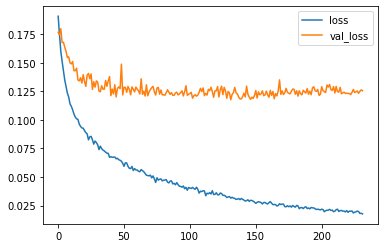

In [13]:
pd.DataFrame(history.history).plot()

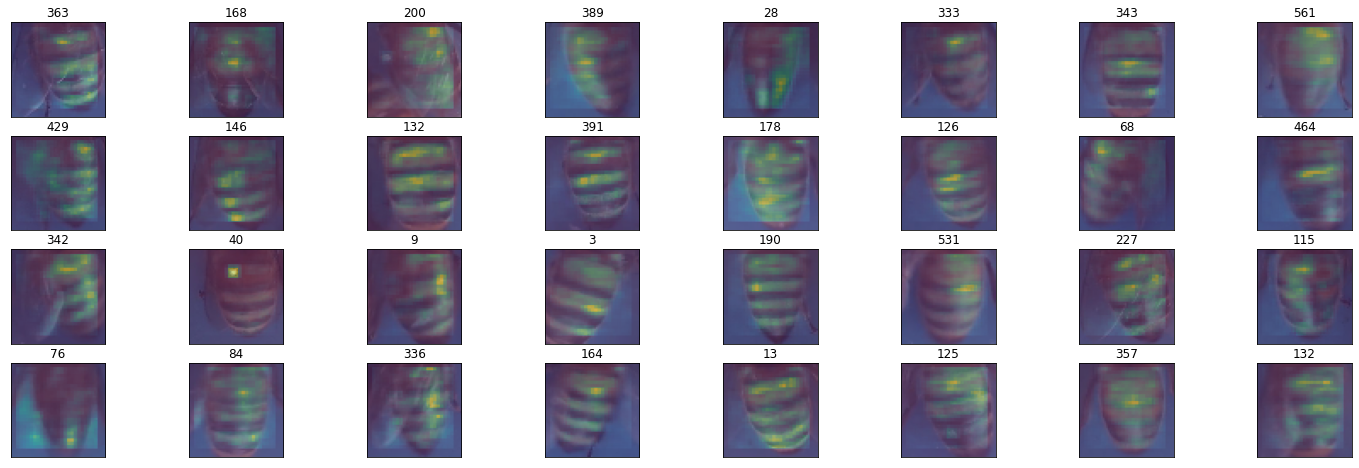

In [14]:
show_sensitivity_maps(model, valid_dataset)

#### Save model

In [ ]:
# model.save("models/triplet_loss.tf")

## Evaluation

In [15]:
ITERATIONS=100
GALLERY_SIZE=10

### Evaluation only ids shared with the training set (validation set)

100%|██████████| 100/100 [01:29<00:00,  1.12it/s]


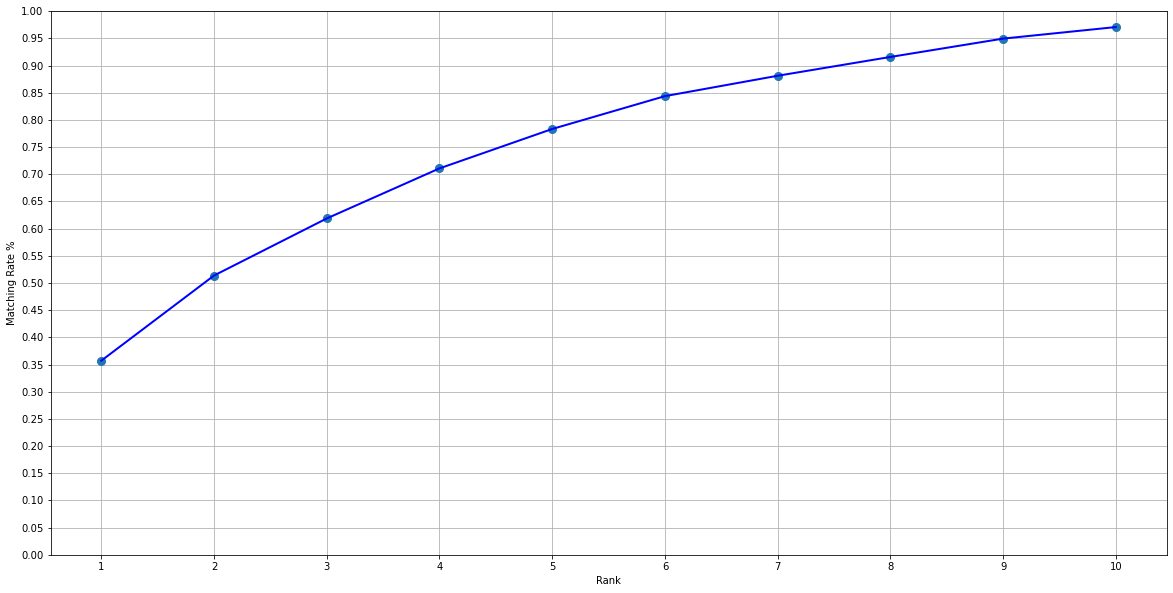

In [16]:
train_ids = train_df.track_tag_id.unique()

valid_with_shared_ids = valid_df[valid_df.track_tag_id.isin(train_ids)]      

valid_with_shared_ids_ranks_means = cmc_evaluation(model, valid_with_shared_ids, iterations=ITERATIONS, gallery_size=GALLERY_SIZE)

plot_cmc(valid_with_shared_ids_ranks_means )

### Evaluation on the whole validation set

In [ ]:
valid_ranks_means = cmc_evaluation(model, valid_df, iterations=ITERATIONS, gallery_size=GALLERY_SIZE)
      
plot_cmc(valid_ranks_means)

### Evaluation on whole test set

In [ ]:
test_ranks_means = cmc_evaluation(model, test_df, iterations=ITERATIONS, gallery_size=GALLERY_SIZE)
         
plot_cmc(test_ranks_means)

In [ ]:
train_ids = train_df.track_tag_id.unique()
test_ids = test_df.track_tag_id.unique()


intersection = set(train_ids) & set(test_ids)

print("Test set has {} Ids.".format(len(test_ids)))
print("Intersection of train and test set {}".format(len(intersection)))

In [ ]:
test_disjoint_train = test_df[~test_df.track_tag_id.isin(train_ids)]

test_disjoint_train_ranks_means = cmc_evaluation(model, test_disjoint_train, iterations=ITERATIONS, gallery_size=GALLERY_SIZE)

plot_cmc(test_disjoint_train_ranks_means)

#### Saving results

In [ ]:
metric_dict = dict()

metric_dict["valid_cmc_only_train_ids"] = valid_with_shared_ids_ranks_means 
metric_dict["valid_cmc"] = valid_ranks_means
metric_dict["test_cmc"] = test_ranks_means
metric_dict["test_cmc_no_ids_overlap"] = test_disjoint_train_ranks_means         

metric_df = pd.DataFrame(metric_dict)
metric_df.to_csv("results/pretraining_triplet_loss_1448_ids.csv")

#### Interactive Query Plotting

In [17]:
get_interactive_plot_query_gallery(model, valid_df)

interactive(children=(IntSlider(value=17, description='query_id', max=34), Checkbox(value=False, description='…